### Predicting errors in basketball free-throw shots

In [413]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm import tqdm
import pdb

import torch
import torch.optim as optim
from torch import nn
from torch.utils.data import DataLoader, TensorDataset

from scipy import io

from sklearn.model_selection import cross_val_score

import random
import torch
def set_seed(seed=None, seed_torch=True):
    if seed is None:
        seed = np.random.choice(2 ** 32)
    random.seed(seed)
    np.random.seed(seed)
    if seed_torch:
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True
    print(f'Random seed {seed} has been set.')


# In case that `DataLoader` is used
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)
SEED = 2021
set_seed(seed=SEED)

Random seed 2021 has been set.


In [5]:
mat = io.loadmat('data_for_tanvi.mat');

In [492]:
importance = io.loadmat('tanvi_data_ix_iz.mat');
# importance['ix'][0]

In [75]:
old_lab_idx=0;

In [508]:
old_lab = pd.DataFrame()
var_names = ['DX','DZ']
for var in var_names:
    dx = mat[var][0][old_lab_idx]
    old_lab[var] = dx.ravel();
nfeat = [20,100,500,1000,1500,1820];
plist = importance['ix'][0][:nfeat]#nfeat; #mat['P'][0][old_lab_idx].shape[1]
for ifeature in plist:
    dx = mat['P'][0][old_lab_idx][:,ifeature];
    old_lab[f'P_{ifeature}'] = dx.ravel()
old_lab.tail(10)

,DX,DZ,P_18,P_463,P_908,P_466,P_131,P_2,P_456,P_658,...,P_1361,P_1453,P_27,P_1017,P_525,P_1012,P_913,P_473,P_468,P_58
34040,3.381908,-0.015266,18.603020,315.653526,0.968031,325.483821,-2.942604,4.182857,0.081426,0.000042,...,0.000322,0.002216,0.000488,-0.001401,-0.003079,0.000107,0.094072,1.913168,335.620258,0.075706
34041,3.507950,-0.018286,19.917336,326.894073,1.202387,348.678793,-3.291126,4.184053,0.111991,-0.001403,...,-0.002641,0.005282,0.000975,0.011781,-0.004423,-0.000978,0.145663,2.654343,371.915280,0.161155
34042,3.771522,-0.018619,22.028342,355.792296,1.134826,394.565313,-3.580356,4.232223,0.076924,-0.001920,...,-0.003578,0.032664,0.000288,0.004877,-0.002954,-0.000507,0.122596,2.153201,437.563679,0.092036
34043,3.562769,-0.004977,20.154886,346.224511,1.324595,365.167493,-3.380583,4.256532,0.138881,-0.001534,...,-0.079783,17.100085,0.000050,0.005488,-0.005473,0.001356,0.096539,1.796043,385.146903,-0.345129
34044,3.816865,-0.027872,23.647210,352.807090,1.567340,411.349971,-4.023089,4.170766,0.142039,-0.000038,...,0.000893,0.002955,0.000578,-0.003664,-0.005794,0.000436,0.178035,2.671284,479.607138,-0.241242
34045,3.681826,-0.025709,22.393956,338.582666,1.497652,385.949390,-3.736219,4.151450,0.138809,0.000735,...,-0.045316,0.556782,0.000468,-0.029551,-0.005579,0.004776,0.209376,3.222464,439.942581,0.805712
34046,3.592657,-0.003343,22.025016,316.091917,1.386822,364.602588,-3.294462,4.068663,0.114750,0.000789,...,-0.002049,0.111167,0.000432,0.002398,-0.004219,-0.000279,0.147481,2.180244,420.558199,-0.062808
34047,3.744163,-0.003159,23.099703,345.779860,1.422008,399.580294,-3.842059,4.159095,0.153214,-0.002473,...,0.001461,0.001497,0.000237,-0.004826,-0.006127,0.000852,0.145289,2.445831,461.751623,-0.128381
34048,3.664669,-0.019723,21.555866,342.776245,1.395159,379.359356,-3.588243,4.195103,0.121315,-0.000106,...,-0.003147,0.104146,0.001262,0.005966,-0.004814,-0.000339,0.125552,2.039330,419.846834,0.175002
34049,3.661634,-0.008487,20.189493,364.526968,0.934330,378.358400,-3.320242,4.329014,0.090746,0.000413,...,-0.000714,-0.001390,0.000094,-0.001559,-0.003447,0.000206,0.068130,1.631125,392.714644,0.089430


In [509]:
old_lab.dropna(inplace=True);
old_lab = old_lab[old_lab['DX']>0]
old_lab.shape

(29551, 52)

In [510]:
df_all=pd.DataFrame()
for i in tqdm(range(1,len(mat['DX'][0])-1), leave=0, position=True):
    df = pd.DataFrame();
    
    for var in var_names:
        dx = mat[var][0][i]
        df[var] = dx.ravel();
    for ifeature in plist:
        dx = mat['P'][0][i][:,ifeature];
        df[f'P_{ifeature}'] = dx.ravel()
        
    df['dataset_id'] = i;
        
    df_all = pd.concat((df_all,df),ignore_index=True)
    
df_all.dropna(inplace=True);
df_all = df_all[df_all['DX']>0];

df_all.shape


 75%|███████▌  | 3/4 [00:00<00:00,  7.89it/s]
                                             

(2078, 53)

In [511]:
df_all.tail(5)

,DX,DZ,P_18,P_463,P_908,P_466,P_131,P_2,P_456,P_658,...,P_1453,P_27,P_1017,P_525,P_1012,P_913,P_473,P_468,P_58,dataset_id
2195,4.309239,-0.003997,26.553794,493.174524,1.820350,555.586238,-3.609663,4.574172,0.430676,5.351116e-03,...,-0.043095,0.000471,-0.009568,-0.012799,-0.001970,-0.179718,-4.298521,625.896214,0.192888,4
2196,4.165729,-0.009699,28.558917,392.968850,2.006582,501.264071,-3.855805,4.189502,0.314896,-1.347273e-02,...,0.110112,0.000123,-0.000060,-0.010148,-0.000020,-0.174416,-2.697434,639.403527,-0.001701,4
2197,4.198891,-0.027651,29.293800,400.034086,1.976238,515.919344,-3.946964,4.196653,0.339517,6.930510e-07,...,19.740879,0.000734,-0.000596,-0.010900,-0.000085,-0.172214,-2.785635,665.375223,0.193715,4
2198,4.294487,-0.040811,28.648080,440.616376,1.547891,542.130825,-3.767863,4.350151,0.287420,5.333734e-02,...,13.195400,0.000976,0.070793,-0.008690,0.010550,-0.191861,-4.125061,667.033381,-0.413571,4
2199,4.138988,0.025461,27.260157,412.197871,1.823442,501.675318,-3.617723,4.289900,0.299681,-6.623728e-05,...,13.718468,0.000145,0.003656,-0.009271,0.001313,-0.199582,-3.558841,610.575993,0.535617,4


In [512]:
X_train = torch.tensor(old_lab.drop(['DX','DZ'],axis=1).to_numpy())
y_train = torch.tensor(old_lab['DX'].to_numpy())

X_test = torch.tensor(df_all.drop(['DX','DZ','dataset_id'],axis=1).to_numpy())
y_test = torch.tensor(df_all['DX'].to_numpy())

In [513]:
g_seed = torch.Generator()
g_seed.manual_seed(SEED)

batch_size = 64
test_data = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_data, batch_size=batch_size,
                         shuffle=False, num_workers=2,
                         worker_init_fn=seed_worker,
                         generator=g_seed)

train_data = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_data, batch_size=batch_size, drop_last=True,
                        shuffle=True, num_workers=2,
                         worker_init_fn=seed_worker,
                         generator=g_seed)

In [514]:
class Net(nn.Module):
    def __init__(self, actv, input_feature_num, hidden_unit_nums, output_feature_num):
        super(Net,self).__init__()
        self.input_feature_num = input_feature_num;
        self.hidden_unit_nums = hidden_unit_nums;
        self.output_feature_num = output_feature_num;
        
        self.mlp = nn.Sequential();
        
        curr_in_num = input_feature_num;
        for i in range(len(hidden_unit_nums)):
            curr_out_num = hidden_unit_nums[i];
            layer = nn.Linear(curr_in_num, curr_out_num);
            curr_in_num = curr_out_num
            
            self.mlp.add_module(f'Linear_{i}', layer)
            
            actv_layer = eval('nn.%s'%actv);
#             print('added activation')
            self.mlp.add_module(f'Activation_{i}', actv_layer)
            
        out_layer = nn.Linear(curr_in_num, output_feature_num);
        self.mlp.add_module('Output', out_layer)
    
    def forward(self, x):
        return self.mlp(x)
    
# input = torch.zeros([100,2]);
# net = Net('ReLU()', input_feature_num=2, hidden_unit_nums=[100,10,5],
#          output_feature_num=1)
# y = net(input);
# print(f'Output shape is {y.shape} for input shape {input.shape}')

In [515]:
net = Net('ReLU()',X_train.shape[1],[100,100,10],1).to('cpu'); #tip: X_train.shape[1] or X_train.size(0)
print(net)

Net(
  (mlp): Sequential(
    (Linear_0): Linear(in_features=50, out_features=100, bias=True)
    (Activation_0): ReLU()
    (Linear_1): Linear(in_features=100, out_features=100, bias=True)
    (Activation_1): ReLU()
    (Linear_2): Linear(in_features=100, out_features=10, bias=True)
    (Activation_2): ReLU()
    (Output): Linear(in_features=10, out_features=1, bias=True)
  )
)


In [551]:
# def train_test_classification(net, criterion, optimizer, train_loader, test_loader,
#                              num_epochs=1, verbose=False, training_plot=True,device='cpu'):
    
#     net.train(); 
#     train_losses = torch.zeros(num_epochs)
#     train_loss, test_loss = [], [];
#     for i_epoch in tqdm(range(num_epochs),position=0,leave=True):
#         running_loss = [];
#         for dat in train_loader:
#             inputs, labels = dat;
#             inputs = inputs.to(device).float();
#             y_true = labels.to(device).float();
            
#             optimizer.zero_grad();
#             y_pred = net.forward(inputs).squeeze();
#             loss = criterion(y_pred, y_true);
            
# #             pdb.set_trace();
            
#             loss.backward();
#             optimizer.step();
            
#             train_losses[i_epoch] = train_losses[i_epoch]+loss.item();
            
#         net.eval();

#         def test(data_loader):
#             net_loss = 0;
#             for i, data in enumerate(data_loader):
#                 inputs, labels = data;
#                 inputs = inputs.to(device).float();
#                 labels = labels.to(device).float();

#                 outputs = net(inputs);

#                 loss = criterion(labels,outputs); #print(loss.item())
#                 net_loss += loss.item();

#             return net_loss

#         train_loss.append(test(train_loader));
#         test_loss.append(test(test_loader));

#     return train_loss, test_loss, train_losses

# # set_seed(SEED);
# net = Net('ReLU()',X_train.shape[1],[1000,100,10],1).to('cpu'); #tip: X_train.shape[1] or X_train.size(0)

# criterion = nn.MSELoss();
# optimizer = optim.Adam(net.parameters(), lr=1e-3);

# num_epochs = 10;
# train_loss, test_loss, train_loss2 = train_test_classification(net, criterion, optimizer, train_loader, test_loader,
#                              num_epochs=num_epochs, verbose=False, training_plot=True,device='cpu')

In [543]:
net = Net('ReLU()',X_train.shape[1],[100,100,10],1).to('cpu'); #tip: X_train.shape[1] or X_train.size(0)

criterion = nn.MSELoss();
optimizer = optim.Adam(net.parameters(), lr=1e-3);

nepoch=500;
yy_pred, yy_pred_test = np.zeros((len(X_train),nepoch)), np.zeros((len(X_test),nepoch))

for i_epoch in tqdm(range(nepoch),position=0,leave=True):
    running_loss = [];
    for dat in train_loader:
        inputs, labels = dat;
        inputs = inputs.float();
        y_true = labels.float();

        optimizer.zero_grad();
        y_pred = net.forward(inputs).squeeze();
        loss = criterion(y_pred, y_true);

#             pdb.set_trace();

        loss.backward();
        optimizer.step();


    net.eval();
    yy_pred[:,i_epoch] = net.forward(X_train.float()).squeeze().detach().numpy()
    yy_pred_test[:,i_epoch] = net.forward(X_test.float()).squeeze().detach().numpy()


100%|██████████| 500/500 [11:20<00:00,  1.50s/it]
No handles with labels found to put in legend.


In [559]:
net

Net(
  (mlp): Sequential(
    (Linear_0): Linear(in_features=50, out_features=100, bias=True)
    (Activation_0): ReLU()
    (Linear_1): Linear(in_features=100, out_features=100, bias=True)
    (Activation_1): ReLU()
    (Linear_2): Linear(in_features=100, out_features=10, bias=True)
    (Activation_2): ReLU()
    (Output): Linear(in_features=10, out_features=1, bias=True)
  )
)

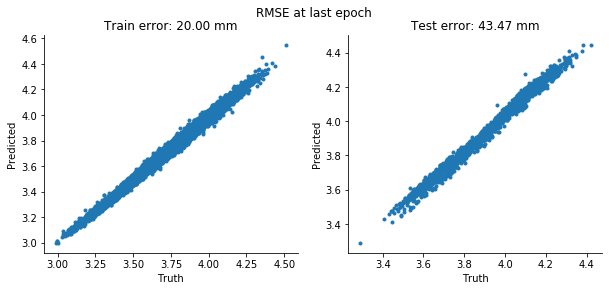

In [557]:
f,ax = plt.subplots(1,2,figsize=(10,4))
ax[0].plot(y_train,yy_pred[:,-1],'.');
mse_train = torch.sqrt(torch.mean((torch.tensor(yy_pred[:,-1])-y_train)**2))
ax[0].set_title(mse_train.item()); ax[0].set_xlabel('Truth'); ax[0].set_ylabel('Predicted');
ax[0].set_title(f'Train error: {mse_train.item()*1000:0.2f} mm'); 

ax[1].plot(yy_pred_test[:,-1],y_test,'.');
mse_test = torch.sqrt(torch.mean((torch.tensor(yy_pred_test[:,-1])-y_test)**2))
ax[1].set_title(f'Test error: {mse_test.item()*1000:0.2f} mm'); 
ax[1].set_xlabel('Truth'); ax[1].set_ylabel('Predicted');

plt.suptitle('RMSE at last epoch');
sns.despine()

In [545]:
mse_train_hand = [torch.sqrt(torch.mean((y_train-yy_pred[:,epoch])**2)) for epoch in range(nepoch)]

In [546]:
mse_test_hand = [torch.sqrt(torch.mean((y_test-yy_pred_test[:,epoch])**2)) for epoch in range(nepoch)]

In [547]:
mse_train_nn = [np.sqrt(criterion(torch.tensor(y_train),torch.tensor(yy_pred[:,epoch])).detach().numpy()) for epoch in range(nepoch)]

/Users/tanviranjan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.


In [548]:
mse_test_nn = [np.sqrt(criterion(torch.tensor(y_test),torch.tensor(yy_pred_test[:,epoch])).detach().numpy()) for epoch in range(nepoch)]

/Users/tanviranjan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.


Text(0.5, 0, 'Epoch')

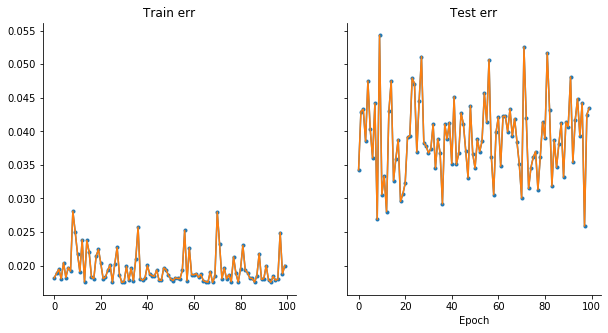

In [550]:
start=400
f,ax = plt.subplots(1,2,figsize=(10,5),sharex=True,sharey=True)
ax[0].plot(mse_train_hand[start:],'.-'); ax[0].plot(mse_train_nn[start:]); ax[0].set_title('Train err')
ax[1].plot(mse_test_hand[start:],'.-'); ax[1].plot(mse_test_nn[start:]); ax[1].set_title('Test err');

sns.despine(); ax[1].set_xlabel('Epoch')

In [558]:
count=0;
for param in net.parameters():
    if param.requires_grad:
        count+=torch.numel(param);
print(count)

16221


In [560]:
net

Net(
  (mlp): Sequential(
    (Linear_0): Linear(in_features=50, out_features=100, bias=True)
    (Activation_0): ReLU()
    (Linear_1): Linear(in_features=100, out_features=100, bias=True)
    (Activation_1): ReLU()
    (Linear_2): Linear(in_features=100, out_features=10, bias=True)
    (Activation_2): ReLU()
    (Output): Linear(in_features=10, out_features=1, bias=True)
  )
)